In [1]:
# import required packages
import time
import numpy as np
import torch
import matplotlib.pyplot as plt

# import MAGI-X packages
from magix import dynamic # dynamic module
from magix.inference import FMAGI # inferred module

## High Frequency High Noise

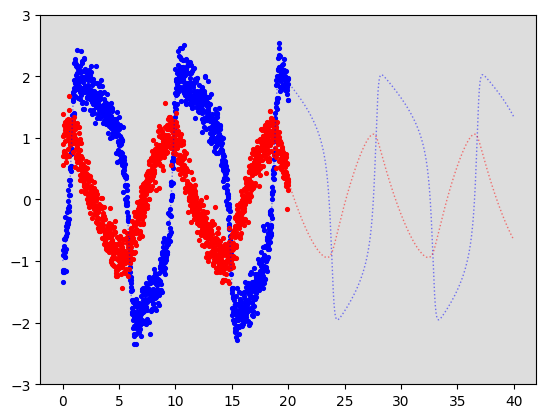

In [2]:
# FN
seed = 637077689 # random seed
example = 'fn' # example
noise = [0.2,0.2] # noise level
no_train = 1281 # number of training point

# read data
data = np.loadtxt('data/%s.txt' %(example))
tdata = data[:,0] # time
xdata = data[:,1:] # component values
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)

# observation
obs = []
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.show()

### Known Dynamic

In [3]:
# known dynamic
torch.manual_seed(seed)
# define known FitzHugh-Nagumo dynamic

def FN_change_ode(theta, change_par, change_time, x, t):
    # theta: a, b, c; x: V, R
    assert x.shape[0] == t.shape[0]
    theta0 = torch.zeros_like(t)
    theta0[t < change_time] = change_par[0]
    theta0[t >= change_time] = change_par[1]
    dVdt = theta[2]*(x[:,0]-torch.pow(x[:,0],3)/3.0+x[:,1]).reshape(-1,1)
    dRdt = -1.0/theta[2]*(x[:,0]-theta0+theta[1]*x[:,1]).reshape(-1,1)
    dxdt = torch.cat((dVdt,dRdt), 1)
    return (dxdt)


def FNode(theta, x, t):
    # theta: a, b, c; x: V, R
    dVdt = theta[2]*(x[:,0]-torch.pow(x[:,0],3)/3.0+x[:,1]).reshape(-1,1)
    dRdt = -1.0/theta[2]*(x[:,0]-theta[0]+theta[1]*x[:,1]).reshape(-1,1)
    dxdt = torch.cat((dVdt,dRdt), 1)
    return (dxdt)

theta = torch.tensor([1.,1.,5.]).double() # initial theta
change_par = [1.5, 0.5]
change_time = 10

fOde = dynamic.odeModule(FNode, theta)
fChangeOde = dynamic.ChangeOdeModule(FN_change_ode, theta, change_par, change_time)

# learning rate
magix_iteration = 1000
# time recording
start_time = time.time()
# call inference class
model_h0 = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
model_h11 = FMAGI(obs,fChangeOde,grid_size=161,interpolation_orders=3)

fChangeOde_list = [dynamic.ChangeOdeModule(FN_change_ode, theta, change_par, change_time=i) for i in [5, 10, 15]]
model_h1 = [FMAGI(obs,f_change,grid_size=161,interpolation_orders=3) for f_change in fChangeOde_list]


/Users/shihaoyang/Workspace/canvas/.venv/magix_robust/lib/python3.12/site-packages/linear_operator/utils/sparse.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():
/Users/shihaoyang/Workspace/canvas/.venv/magix_robust/lib/python3.12/site-packages/linear_operator/utils/sparse.py:63: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:643.)
  res = cls(index_tensor, value_tensor, interp_size)


In [4]:
# map inference
tinfer_h0, xinfer_h0 = model_h0.map(max_epoch=magix_iteration,
                                    learning_rate=1e-2,decay_learning_rate=False,
                                    robust=False,robust_eps=0.10,
                                    hyperparams_update=True,dynamic_standardization=False,
                                    verbose=True,returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 200.716821
200/1000 iteration: 11.226338
400/1000 iteration: 9.396577
600/1000 iteration: 8.522828
800/1000 iteration: 7.955437
1000/1000 iteration: 7.544908
run time: 31.04 seconds


In [5]:
tinfer, xinfer = model_h1[1].map(max_epoch=magix_iteration,
                                 learning_rate=1e-2,decay_learning_rate=False,
                                 robust=False,robust_eps=0.10,
                                 hyperparams_update=True,dynamic_standardization=False,
                                 verbose=True,returnX=True)

1/1000 iteration: 205.000444
200/1000 iteration: 11.450900
400/1000 iteration: 9.571425
600/1000 iteration: 8.669619
800/1000 iteration: 9.001846
1000/1000 iteration: 8.421672


In [9]:
fOde.theta

Parameter containing:
tensor([0.2046, 0.3692, 3.0056])

In [10]:
model_h1[1].fOde.theta

Parameter containing:
tensor([0.2046, 0.3692, 3.0056])

In [11]:
model_h1[1].fOde.change_par

Parameter containing:
tensor([0.2434, 0.1922])

In [ ]:
# inferred 
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tinfer, xinfer[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('Inferred Trajectory')
plt.show()

In [ ]:
# reconstruction 
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
xrecon = model.predict(x0,trecon) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(trecon, xrecon[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('Inferred Trajectory')
plt.show()

## Low Frequency Low Noise

In [ ]:
# FN
seed = 637077689 # random seed
example = 'fn' # example
noise = [0.1,0.1] # noise level
no_train = 41 # number of training point

# read data
data = np.loadtxt('data/%s.txt' %(example))
tdata = data[:,0] # time
xdata = data[:,1:] # component values
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)

# observation
obs = []
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.show()

### Unknown Dynamic

In [ ]:
# unknown dynamic
torch.manual_seed(seed)
# define neural network dynamic
magix_node = [no_comp,512,no_comp]
fOde = dynamic.nnModule(magix_node)
# learning rate
magix_iteration = 1000
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=magix_iteration,
                           learning_rate=1e-3,decay_learning_rate=True,
                           robust=True,robust_eps=0.10,
                           hyperparams_update=True,dynamic_standardization=True,
                           verbose=True,returnX=True) 
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

In [ ]:
# inferred 
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tinfer, xinfer[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('Inferred Trajectory')
plt.show()

In [ ]:
# reconstruction 
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
xrecon = model.predict(x0,trecon) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(trecon, xrecon[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('Inferred Trajectory')
plt.show()

### Known Dynamic

In [ ]:
# known dynamic
torch.manual_seed(seed)
# define known FitzHugh-Nagumo dynamic
def FNode(theta, x):
    # theta: a, b, c; x: V, R
    dVdt = theta[2]*(x[:,0]-torch.pow(x[:,0],3)/3.0+x[:,1]).reshape(-1,1)
    dRdt = -1.0/theta[2]*(x[:,0]-theta[0]+theta[1]*x[:,1]).reshape(-1,1)
    dxdt = torch.cat((dVdt,dRdt), 1)
    return (dxdt)
theta = torch.tensor([1.,1.,5.]).double() # initial theta
fOde = dynamic.odeModule(FNode, theta)
# learning rate
magix_iteration = 1000
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=magix_iteration,
                           learning_rate=1e-2,decay_learning_rate=False,
                           robust=False,robust_eps=0.10,
                           hyperparams_update=True,dynamic_standardization=False,
                           verbose=True,returnX=True) 
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

In [ ]:
# inferred 
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tinfer, xinfer[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('Inferred Trajectory')
plt.show()

In [ ]:
# reconstruction 
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
xrecon = model.predict(x0,trecon) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(trecon, xrecon[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('Inferred Trajectory')
plt.show()